# Predicting maximum daily Electricity with (S)ARIMA



In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima, plot_acf, plot_pacf
from pmdarima import ARIMA
from pmdarima.model_selection import train_test_split

import pmdarima as pm

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

import holidays

**TOC:**


1.   Load the data
2.   EDA
3.   Split the dataset
4.   Select the (S)ARIMA model with auto_arima
5.   Plot predictions vs test and calculate metrics
6.   Make future predictions beyond the dataset

**Remark:** We will be using ARIMA from the library "pmdarima" because of its broad functionallity. If you prefer ARIMA from the "statsmodels" library you will need to do some minor changes in the code because some commands have a slightly different syntax.



## 1. Load the data

We will:


*   Load the data
*   Check if index is 'DatetimeIndex'
*   Plot the data to visualy inspect it.



In [3]:
file_path_read = 'https://raw.githubusercontent.com/tribp/Forecasting/main/datasets/Elia/Elia_2015-2024_daily_max.parquet'
df = pd.read_parquet(file_path_read)
df.head()

,totalload,mostrecentforecast,dayaheadforecast,weekaheadforecast
datetime,,,,
2015-01-01 00:00:00+01:00,10211.60,9496.05,10911.55,11046.90
2015-01-02 00:00:00+01:00,11501.80,10597.84,11328.92,11825.52
2015-01-03 00:00:00+01:00,11676.63,11664.82,11655.24,11813.24
2015-01-04 00:00:00+01:00,11422.35,11059.78,11070.12,10863.09
2015-01-05 00:00:00+01:00,13404.97,12673.07,12715.32,12201.15


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2015-01-01 00:00:00+01:00 to 2024-12-31 00:00:00+01:00
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   totalload           3653 non-null   float64
 1   mostrecentforecast  3653 non-null   float64
 2   dayaheadforecast    3653 non-null   float64
 3   weekaheadforecast   3651 non-null   float64
dtypes: float64(4)
memory usage: 142.7 KB


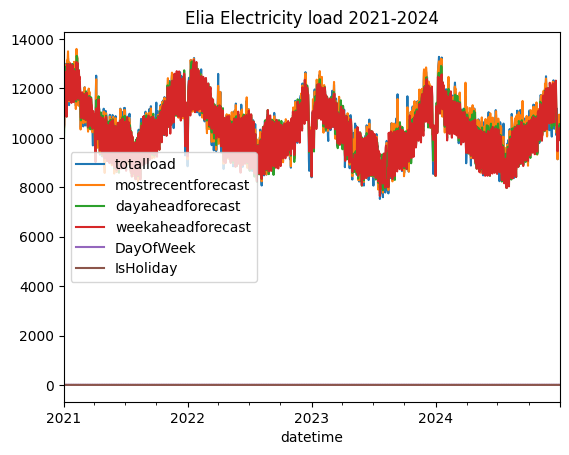

In [26]:
df.plot(title='Elia Electricity load 2021-2024')
plt.show()

## 2. EDA

We wil perform a small EDA, Exploratory Data Analysis

We start doing an 'ETS' decomposistion (ETS =
Error-Trend-Seasonality).

Time series = Trend + Seasonality + Error

We notice:


*   The time series has a clear upwards trend
*   The time series has a clear seasonal behaviour

In order to use and model with ARIMA, the time series must be **stationary**. This simply means that it's statistic parameters, like "mean" and "standard deviation" must be constant over time.

Before performing the appropriate ADF-Augmented-Dicky-Fuller
 test, we can already see visualy that it will not be the case since:

 * a trend implicates that the mean can't be constant over time
 * a seasonality implicates a varying "variance" (σ<sup>
2</sup>) over time


**remark:** Variance=(Standard Deviation) <sup>2</sup>




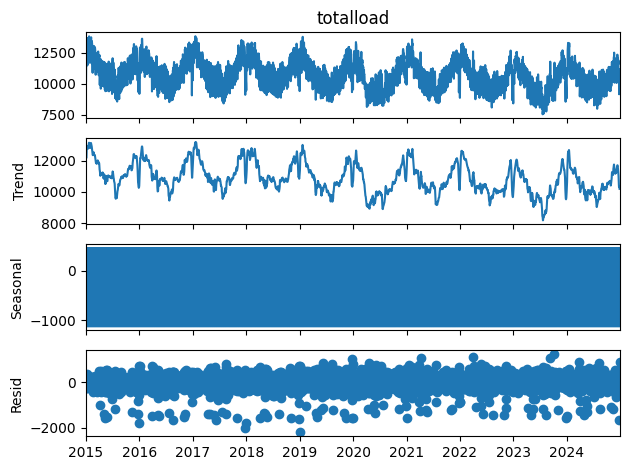

In [6]:
seasonal_decompose(df['totalload']).plot()
plt.show()

In [7]:
# Perform Augmented Dicky Fuller test: p-value must be < 0.05 to be stationary
test_stationarity = adfuller(df['totalload'])
print('p-value: %f' % test_stationarity[1])
print(f'Time series is {"not " if test_stationarity[1] > 0.05 else ""}stationary')

p-value: 0.000063
Time series is stationary


## 3. Split the dataset

Our final goal is to predict the next 30 days. Therefore we will not take the classical 80-20 split for train-test but only take the last 30 days for testing the model

**Important:** We will also restrict the data from 2021 upto 2024

In [8]:
# set the horizon forecast and we will also split the dataset accordingly
horizon = 30
# Restrict the data from 2021 upto end 2024
df = df[(df.index >= '2021-01-01') & (df.index <= '2024-12-31')]
train = df[:-horizon]
test = df[-horizon:]

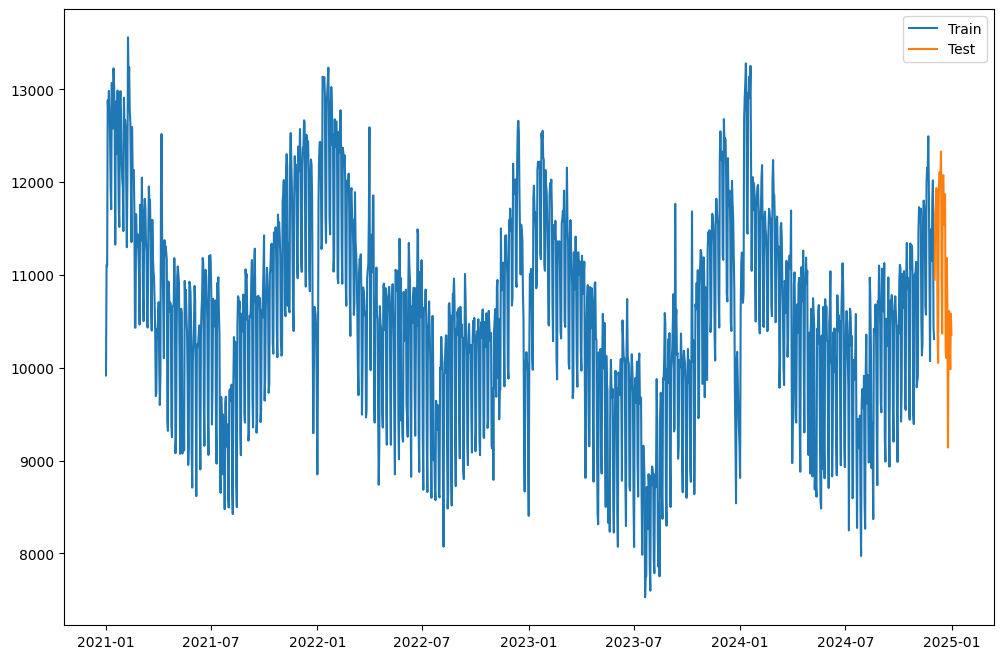

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(train['totalload'], label='Train')
plt.plot(test['totalload'], label='Test')
plt.legend(loc='best')
plt.title('Elia Electricity load 2021-2024')
plt.xlabel('Time')
plt.ylabel('MW')
plt.show()

## 4. Select the (S)ARIMA model with auto_arima

We will use auto_arima from the pmdarima library to automatically search the best parameters. Since we noticed a 12 month and 7 day seasonality we will be using a "Seasonal Arima" or "Sarima. Besides the classical (p,d,q) parameters for "ARIMA" it will also give (P,D,Q). These are the equivalent parameters but for the seasonal behaviour.

In [10]:
sarima_model = auto_arima(train['totalload'], seasonal=True, m=7, trace=True, stepwise=False)
print(sarima_model.summary)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=23094.030, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=22549.401, Time=3.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=22339.341, Time=9.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=22061.827, Time=4.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=8.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=6.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=21855.605, Time=5.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=7.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=11.26 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=23093.186, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=22495.237, Time=2.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=22255.452, Time=4.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=21918.127, Time=5.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=21716.853, Time=2.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=12.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=22668.200, Time=1.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=22226.465, Time=3.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=22092.163, Time=10.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=21871.108, Time=4.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=5.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=10.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=21688.035, Time=6.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=12.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[7] intercept   : AIC=22662.870, Time=1.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,1)[7] intercept   : AIC=22207.071, Time=4.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,2)[7] intercept   : AIC=22060.271, Time=11.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,0)[7] intercept   : AIC=21855.208, Time=3.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=inf, Time=9.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(2,0,0)[7] intercept   : AIC=21685.774, Time=10.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[7] intercept   : AIC=22629.199, Time=2.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,1)[7] intercept   : AIC=22208.859, Time=5.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=21840.313, Time=7.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[7] intercept   : AIC=22586.775, Time=3.69 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=23095.253, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=22530.872, Time=1.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=22300.092, Time=2.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=21971.801, Time=3.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=10.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=21763.986, Time=2.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=6.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=13.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=22806.806, Time=1.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=22249.303, Time=6.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=22085.813, Time=6.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=5.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=7.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=22.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=6.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=10.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=22665.060, Time=1.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=22208.252, Time=4.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=22051.114, Time=9.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=3.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=9.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=10.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[7] intercept   : AIC=22662.289, Time=2.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[7] intercept   : AIC=inf, Time=5.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,0)[7] intercept   : AIC=inf, Time=7.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[7] intercept   : AIC=22601.967, Time=3.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=22898.006, Time=0.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=22415.192, Time=1.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[7] intercept   : AIC=22224.396, Time=4.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=21924.052, Time=3.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=10.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=21721.328, Time=3.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=12.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=22644.130, Time=1.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=22209.026, Time=3.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=22058.232, Time=10.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=3.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=10.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=11.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=22509.371, Time=3.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=22210.646, Time=12.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=16.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[7] intercept   : AIC=inf, Time=8.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[7] intercept   : AIC=22883.334, Time=0.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=22387.985, Time=2.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,2)[7] intercept   : AIC=22192.281, Time=3.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,0)[7] intercept   : AIC=21900.224, Time=3.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=13.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=21701.922, Time=7.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[7] intercept   : AIC=22645.169, Time=2.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,1)[7] intercept   : AIC=22217.075, Time=4.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=9.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[7] intercept   : AIC=22644.447, Time=3.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[7] intercept   : AIC=22791.254, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[7] intercept   : AIC=22338.159, Time=2.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,0)[7] intercept   : AIC=21887.626, Time=8.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[7] intercept   : AIC=22504.424, Time=3.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[7] intercept   : AIC=22285.630, Time=0.96 sec

Best model:  ARIMA(0,1,3)(2,0,0)[7] intercept
Total fit time: 591.511 seconds
<bound method ARIMA.summary of ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(2, 0, 0, 7),
      suppress_warnings=True)>


In [11]:
sarima_model

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(2, 0, 0, 7),
      suppress_warnings=True)

**Conclusion:** We visually saw and calculated via ADF that the time series was NOT stationary and thus expected the model to perform a differtiation on the data. But nevertheless the model did not , (p,d,q) where d=0 !!!, and returns a model that performs better without.

## 5. Plot predictions and calculate metrics

In [12]:
test_predictions = sarima_model.predict(n_periods=horizon)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


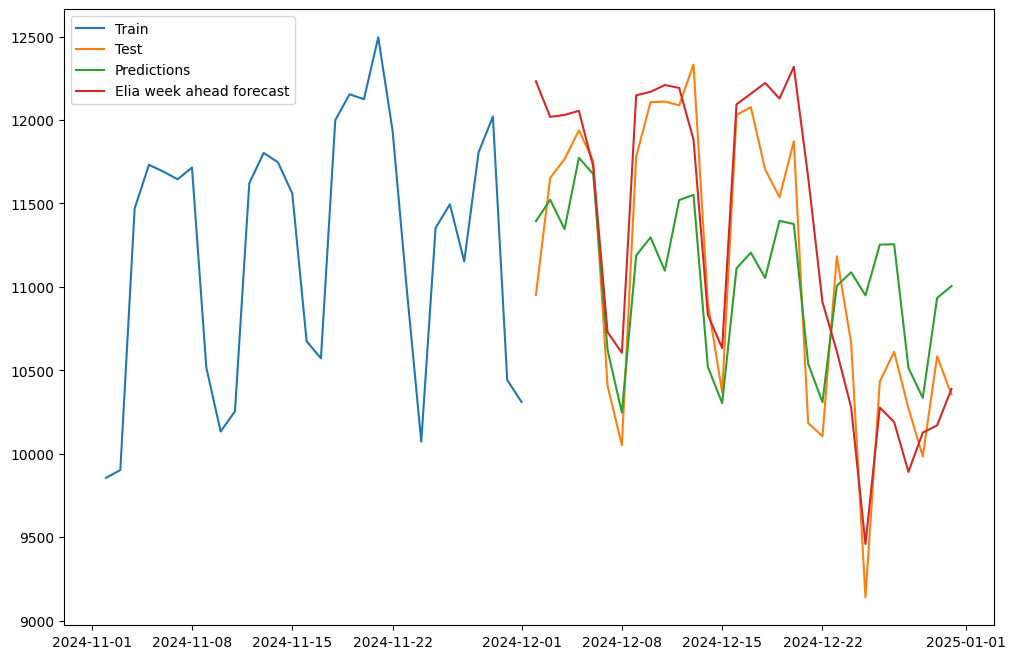

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(train['totalload'][-30:], label='Train')
plt.plot(test['totalload'][-30:], label='Test')
plt.plot(test_predictions, label='Predictions')
plt.plot(test['weekaheadforecast'][-30:], label='Elia week ahead forecast')
plt.legend(loc='best')
plt.title('Elia Electricity load 2021-2024')
plt.xlabel('Time')
plt.ylabel('MW')
plt.show()

In [14]:
print(f'Test MAE: {mean_absolute_error(test["totalload"], test_predictions):.3f}')
print(f'Test RMSE: {root_mean_squared_error(test["totalload"], test_predictions):.3f}')
print(f'Test MAPE: {100*mean_absolute_percentage_error(test["totalload"], test_predictions):.2f} %')

Test MAE: 498.651
Test RMSE: 615.847
Test MAPE: 4.54 %


**Compare with Elia week ahead forecasts**

In [15]:
print(f'Test MAE: {mean_absolute_error(test["totalload"], test["weekaheadforecast"]):.3f}')
print(f'Test RMSE: {root_mean_squared_error(test["totalload"], test["weekaheadforecast"]):.3f}')
print(f'Test MAPE: {100*mean_absolute_percentage_error(test["totalload"], test["weekaheadforecast"]):.2f} %')

Test MAE: 371.595
Test RMSE: 498.763
Test MAPE: 3.43 %


## 6.   We will add exogenous variables to enhance the model

Energy demand is closely related to DayOfWeek and Holidays. We will add both to the SARIMAX model

In [16]:
import holidays
import json
import requests
from datetime import datetime

In [17]:
# Step 1: Load the Belgium holidays
be_holidays = holidays.Belgium()

# step 2: Load the school holidays from the file
file_path = 'https://raw.githubusercontent.com/tribp/Forecasting/main/datasets/holidays/schoolvakanties.json'

response = requests.get(file_path)
school_holidays = response.json()

# step 3: Extend the be_holidays dictionary with the school holidays
for year, holidays_dict in school_holidays.items():
    for date_str, holiday_name in holidays_dict.items():
        date_obj = datetime.strptime(date_str, '%Y-%m-%d').date()
        be_holidays[date_obj] = holiday_name

# Convert be_holidays to a list of datetime64[ns]
be_holidays_dates = pd.to_datetime(list(be_holidays.keys()))

In [18]:
# Add both columns to be used as exogenous variables
# Remark: ARIMA can not handle boolean so we cast to int32 (0 or 1)
df['DayOfWeek'] = df.index.dayofweek
df['IsHoliday'] = pd.to_datetime(df.index.date).isin(be_holidays_dates).astype('int32')


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2021-01-01 00:00:00+01:00 to 2024-12-31 00:00:00+01:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   totalload           1461 non-null   float64
 1   mostrecentforecast  1461 non-null   float64
 2   dayaheadforecast    1461 non-null   float64
 3   weekaheadforecast   1459 non-null   float64
 4   DayOfWeek           1461 non-null   int32  
 5   IsHoliday           1461 non-null   int32  
dtypes: float64(4), int32(2)
memory usage: 68.5 KB


## 6.1 We split the dataset as before

In [20]:
# Restrict the data from 2021 upto end 2024
df = df[(df.index >= '2021-01-01') & (df.index <= '2024-12-31')]
train = df[:-horizon]
test = df[-horizon:]

In [21]:
sarimax_model = auto_arima(
    train['totalload'],
    seasonal=True,
    m=7,
    stepwise=False,
    X=train.iloc[:,-2:])  # we set the two last columns as exogenous ('DayOfWeek' and 'IsHoliday')
sarimax_model.fit(train['totalload'])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 7),
      suppress_warnings=True)

In [22]:
sarimax_model

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 7),
      suppress_warnings=True)

In [23]:
test_predictions_SM = sarimax_model.predict(
    n_periods=horizon,
    X = test.iloc[:,-2:])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


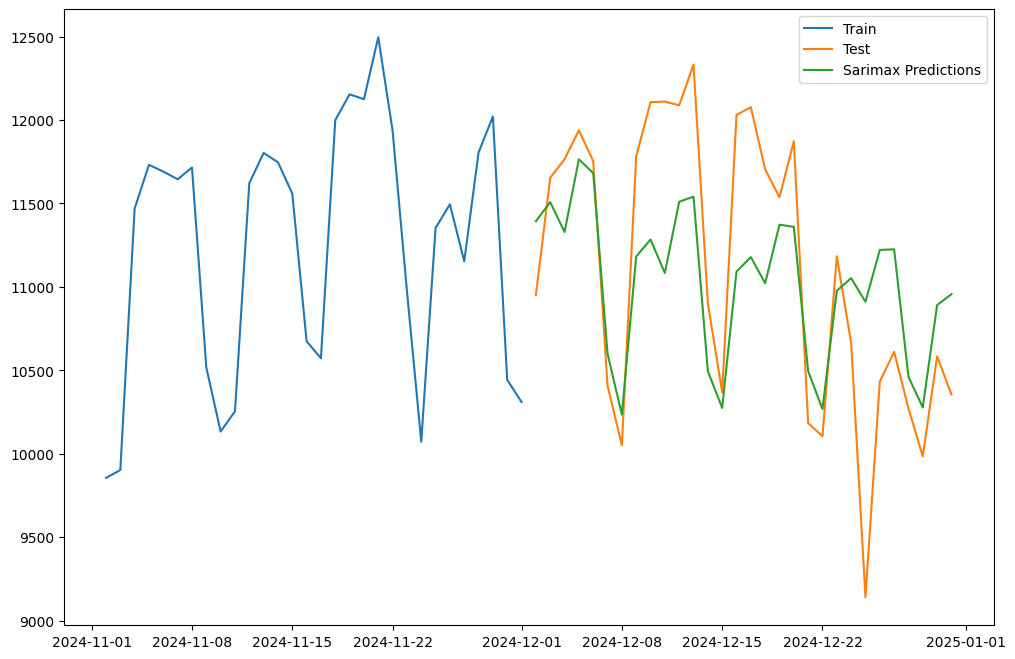

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(train['totalload'][-30:], label='Train')
plt.plot(test['totalload'][-30:], label='Test')
plt.plot(test_predictions_SM, label='Sarimax Predictions')
plt.legend(loc='best')
plt.show()

In [25]:
print(f'Test MAE: {mean_absolute_error(test["totalload"], test_predictions_SM):.3f}')
print(f'Test RMSE: {root_mean_squared_error(test["totalload"], test_predictions_SM):.3f}')
print(f'Test MAPE: {100*mean_absolute_percentage_error(test["totalload"], test_predictions_SM):.2f} %')

Test MAE: 493.073
Test RMSE: 611.206
Test MAPE: 4.47 %


## 6.2 Adding confidence intervals

### Getting Different Confidence Intervals (95%, 80%, 70%)

You can calculate different confidence intervals by setting different values for alpha:

*   95% CI → alpha=0.05
*  80% CI → alpha=0.20
*  70% CI → alpha=0.30

In [27]:
test_predictions_SM, conf_interval_95 = sarimax_model.predict(n_periods=horizon, return_conf_int=True, alpha=0.05, X = test.iloc[:,-2:])
_, conf_interval_80 = sarimax_model.predict(n_periods=horizon, return_conf_int=True, alpha=0.20, X = test.iloc[:,-2:])
_, conf_interval_70 = sarimax_model.predict(n_periods=horizon, return_conf_int=True, alpha=0.30, X = test.iloc[:,-2:])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

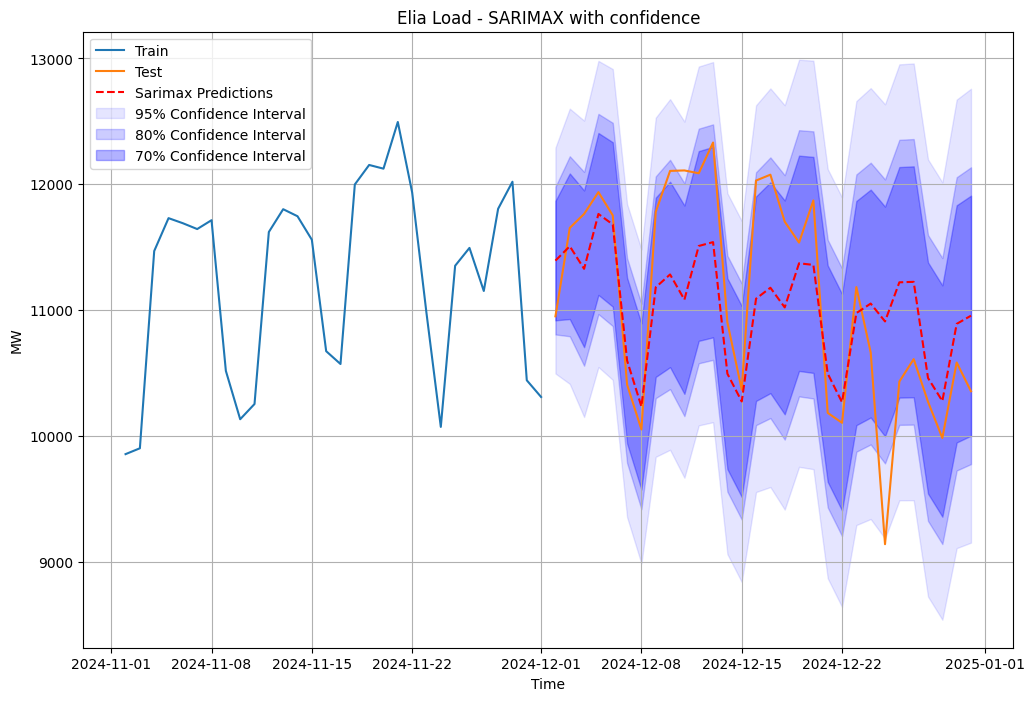

In [42]:
# Plot train, test, predictions and intevals
plt.figure(figsize=(12, 8))
plt.plot(train['totalload'][-30:], label='Train')
plt.plot(test['totalload'][-30:], label='Test')
plt.plot(test_predictions_SM, label='Sarimax Predictions',linestyle='--', color='r')

# Plot Confidence intervals
plt.fill_between(test.index,
                 conf_interval_95[:, 0],
                 conf_interval_95[:, 1],
                 color='b', alpha=0.1,
                 label='95% Confidence Interval')

plt.fill_between(test.index,
                 conf_interval_80[:, 0],
                 conf_interval_80[:, 1],
                 color='b', alpha=0.2,
                 label='80% Confidence Interval')

plt.fill_between(test.index,
                 conf_interval_70[:, 0],
                 conf_interval_70[:, 1],
                 color='b', alpha=0.3,
                 label='70% Confidence Interval')

plt.title('Elia Load - SARIMAX with confidence')
plt.xlabel('Time')
plt.ylabel('MW')
plt.grid()
plt.legend(loc='best')
plt.savefig('sarimax_predictions.png')
plt.show()